# Enron - How many POIs can we predict?

### Index

1. Set variables
2. Data cleansing
3. New features
4. Preparing the data for the split
5. Spliting data into train and test
6. Selecting features
7. Testing models
8. Tuning Algorithm Parameters

In [1]:
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier
from sklearn import model_selection
from time import time
import pandas as pd
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

from sklearn.cross_validation import StratifiedShuffleSplit
    
# Preprocessing
from sklearn.preprocessing import  MaxAbsScaler, StandardScaler, MinMaxScaler

#Models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest,chi2, f_classif
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.tree import DecisionTreeClassifier

#Feature selection
from sklearn.decomposition import PCA,RandomizedPCA, TruncatedSVD
from sklearn.feature_selection import SelectKBest,chi2, f_regression


#pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV

C:\Users\lieby\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\lieby\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In the next steps the data will be cleaned, if you want to understand the process, check: 
https://github.com/liebycardoso/ML_Enron/blob/master/Enron_Data_Analysis.ipynb

### 1. Set variables

In [2]:
target_label = 'poi'                

financial_features_list = [
    'bonus',
    'deferral_payments',
    'deferred_income',
    'director_fees',
    'exercised_stock_options',
    'expenses',
    'loan_advances',
    'long_term_incentive',
    'other',
    'restricted_stock',
    'restricted_stock_deferred',
    'salary'
]

features_list = [target_label] + financial_features_list  

### 2. Data cleansing

In [3]:
with open("P:/Nanodegree/ML/ud120-projects/tools/final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Task 2: Remove outliers
outliers = ["TOTAL", "THE TRAVEL AGENCY IN THE PARK", "LOCKHART EUGENE E", "CHAN RONNIE"]
for outlier in outliers :
    data_dict.pop(outlier, 0)


def update_dict_value(key, items, values, dict_obj):
    index = 0
    for item in items:     
        dict_obj[key][item] = values[index]
        index += 1
    return dict_obj       

    
data_dict = update_dict_value(
              'BELFER ROBERT',
              ['deferred_income','deferral_payments', 'expenses', 
               'director_fees', 'total_payments', 'exercised_stock_options',
               'restricted_stock','restricted_stock_deferred',
               'total_stock_value'], 
              [-102500,'NaN',3285,102500, 3285,'NaN', 44093,-44093,'NaN'],
              data_dict)


data_dict = update_dict_value(
              'BHATNAGAR SANJAY',
              ['other', 'expenses', 'director_fees', 'total_payments',
               'exercised_stock_options','restricted_stock',
               'restricted_stock_deferred','total_stock_value'],
              ['NaN',137864, 'NaN', 137864, 15456290, 
               2604490, -2604490, 15456290],
               data_dict)


### 3. New features

In [4]:
for key in data_dict:
    key_values = data_dict[key]

    total_msg = (data_dict[key]['to_messages'] + 
                 data_dict[key]['from_messages'])
    
    total_poi_msg = (data_dict[key]['from_poi_to_this_person'] +
                     data_dict[key]['from_this_person_to_poi'] + 
                     data_dict[key]['shared_receipt_with_poi'])     
        
    try:
        data_dict[key]['message_poi_ratio'] = np.round((float(total_poi_msg) / 
                                           float(total_msg)), decimals=2)*100
    except:
        data_dict[key]['message_poi_ratio'] = "NaN"
        
    try:
        data_dict[key]['message_others_ratio'] = np.round(((float(total_msg) - float(total_poi_msg)) / 
                                          float(total_msg)), decimals=2)*100
    except:
        data_dict[key]['message_others_ratio'] = "NaN"

features_list = features_list + ['message_poi_ratio','message_others_ratio'] 



### 4. Preparing the data for the split

In [5]:
# Store to my_dataset for easy export below.
my_dataset = data_dict

enron_df = pd.DataFrame.from_dict(data_dict, orient='index', dtype=float)

# Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, remove_NaN=True, sort_keys = True)
labels, features = targetFeatureSplit(data)

### 5. Spliting data into train and test

In [6]:

# transformed version of X
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_scaled = scaler.fit_transform(features)

# Split the dataset into train and test
features_train, features_test, labels_train, labels_test = model_selection.train_test_split(features, 
                                                                                            labels,  
                                                                                            test_size=0.3, 
                                                                                            random_state=42)

Since tje features have quite differente value ranges and some of them are discrete and some of them take continous values, I need to scale them first. Removing mean and dividing the standard deviation o features respectively, this one of the most commonly used preprocessing step.

# 6. Selecting features

In [7]:
# Pearson correlation on selected features
enron_df[features_list].corr()

,poi,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,message_poi_ratio,message_others_ratio
poi,1.000000,0.302384,-0.107254,-0.265665,NaN,0.481875,0.055209,0.999851,0.254723,0.119166,0.218074,NaN,0.264976,0.278311,-0.278311
bonus,0.302384,1.000000,0.293543,-0.411659,NaN,0.506998,0.033799,0.973826,0.625259,0.376371,0.376992,0.118222,0.523190,-0.082795,0.082795
deferral_payments,-0.107254,0.293543,1.000000,-0.881500,NaN,0.006560,0.004800,-1.000000,0.042448,0.385829,0.115088,-0.217200,0.455884,0.247904,-0.247904
deferred_income,-0.265665,-0.411659,-0.881500,1.000000,-0.471247,-0.308076,0.085678,1.000000,-0.331715,-0.185219,-0.133786,0.171881,-0.353816,-0.146486,0.146486
director_fees,NaN,NaN,NaN,-0.471247,1.000000,0.769988,-0.521463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exercised_stock_options,0.481875,0.506998,0.006560,-0.308076,0.769988,1.000000,0.066763,0.960259,0.500016,0.535934,0.689184,-0.953665,0.607324,0.104583,-0.104583
expenses,0.055209,0.033799,0.004800,0.085678,-0.521463,0.066763,1.000000,0.658681,-0.100766,0.062874,0.060546,-0.527262,0.145364,0.141256,-0.141256
loan_advances,0.999851,0.973826,-1.000000,1.000000,NaN,0.960259,0.658681,1.000000,1.000000,1.000000,1.000000,NaN,0.535252,-0.816928,0.816928
long_term_incentive,0.254723,0.625259,0.042448,-0.331715,NaN,0.500016,-0.100766,1.000000,1.000000,0.529398,0.635172,-0.186597,0.484114,-0.043915,0.043915
other,0.119166,0.376371,0.385829,-0.185219,NaN,0.535934,0.062874,1.000000,0.529398,1.000000,0.650015,-0.029366,0.606903,0.037809,-0.037809


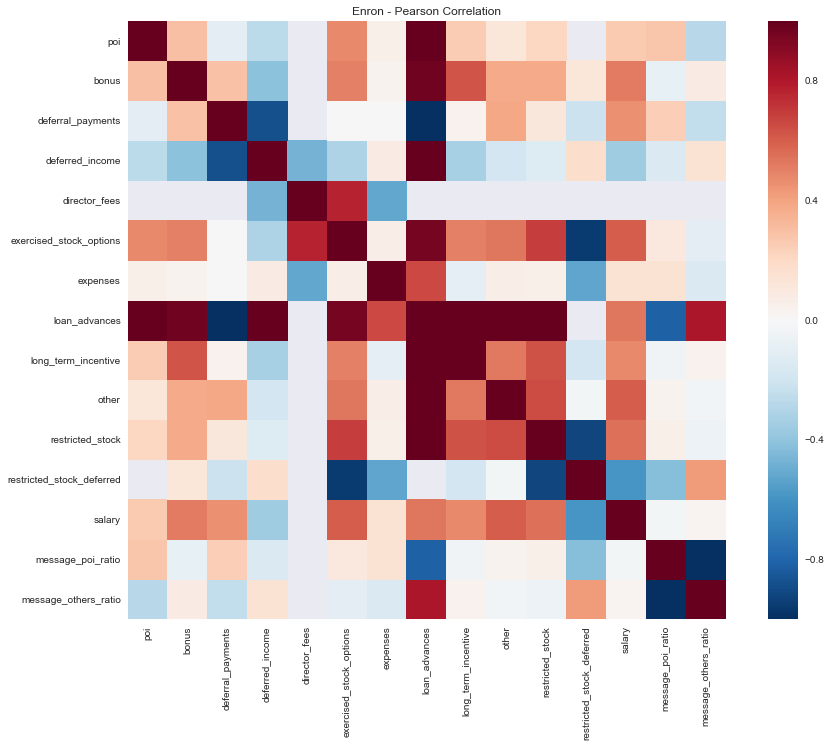

In [20]:
corr = enron_df[features_list].corr()
f, ax = plt.subplots(figsize=(15, 11))

# Draw the heatmap using seaborn
sb.heatmap(corr, vmax=.8, square=True)
sb.plt.title('Enron - Pearson Correlation');

For now I don't know exactly the number of features I want to use, so I decided to use PCA for identify the most important features and explain the variance.

In [14]:
for i in range(1,15):
    pca = PCA(svd_solver='auto', n_components=i)
    x = pca.fit(features_train).explained_variance_ratio_.sum()
    print i,":", x    

1 : 0.861553776228
2 : 0.950132015149
3 : 0.972382607421
4 : 0.984291217742
5 : 0.992901638071
6 : 0.997163221638
7 : 0.998629887008
8 : 0.99974306717
9 : 0.99987985016
10 : 0.999974804349
11 : 0.999991386478
12 : 0.999999999982
13 : 0.999999999993
14 : 1.0


In this decomposition, the vector array provided by ratio indicates that most of the information is concentrated into the first 2 compontents . You saw this same sort of result after the factor analysis. it's therefore possible to reduce the entire dataset to just two componentes, providing a reduction of noise and redundant information from the original dataset.

Let's see which variables are the most important:

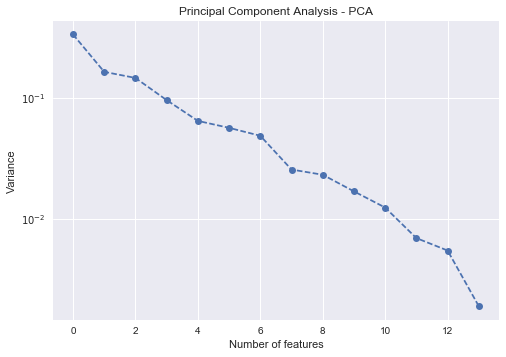

In [19]:
from sklearn.preprocessing import StandardScaler

z_scaler = MinMaxScaler(feature_range=(0, 1))

z_data = z_scaler.fit_transform(features_train)
pca_trafo = PCA().fit(z_data);

plt.semilogy(pca_trafo.explained_variance_ratio_, '--o')
plt.title('Principal Component Analysis - PCA')
plt.xlabel('Number of features')
plt.ylabel('Variance');

In [24]:
pca = PCA(n_components=14)
pca.fit_transform(features_train)
pca_df = pd.DataFrame(zip(features_list[1:],
                          np.round(pca.explained_variance_ratio_, decimals=5)*100), 
                      columns=['feature','variance_ratio'])
#pca_df.sort_values(by='variance_ratio',ascending = False)
pca_df

,feature,variance_ratio
0,bonus,86.155
1,deferral_payments,8.858
2,deferred_income,2.225
3,director_fees,1.191
4,exercised_stock_options,0.861
5,expenses,0.426
6,loan_advances,0.147
7,long_term_incentive,0.111
8,other,0.014
9,restricted_stock,0.009


I really don't wanna that the features negatively impact my model performance. I'll spend more time on this and try SelecKbest for in this task. 

First of all, I scaled the data with MinMaxScaler (range 0, 1), then I applyied SelectKBest chi squared statistical test, cause this test need non-negative features. After that I used SelectKBest ANOVA F-value statistical test on the raw data, in a way I could compare the results.

In [23]:
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(features)

selector = SelectKBest(chi2, k='all').fit(features_scaled, labels)
k_best = SelectKBest(f_classif,k='all').fit(features, labels)   

# Format values
kbest_pd = pd.DataFrame(zip(features_list[1:],
                            k_best.scores_, # K best score                            
                            selector.scores_), # chi2
                        columns = ['feature','anova', 'chi2'])
print "SelectKBest: "
print kbest_pd.sort_values(by='anova',ascending = False)

SelectKBest: 
                      feature      anova      chi2
4     exercised_stock_options  22.087532  6.246159
0                       bonus  20.524645  5.048256
11                     salary  18.003740  2.989183
2             deferred_income  11.320185  0.338413
12          message_poi_ratio   9.839077  3.394583
7         long_term_incentive   9.772104  2.497366
9            restricted_stock   8.694888  2.463442
6               loan_advances   7.125382  6.634816
5                    expenses   5.287549  1.293600
8                       other   4.143788  1.703679
3               director_fees   1.972788  1.508957
13       message_others_ratio   1.485396  0.404153
10  restricted_stock_deferred   0.767702  0.008756
1           deferral_payments   0.236711  0.094344


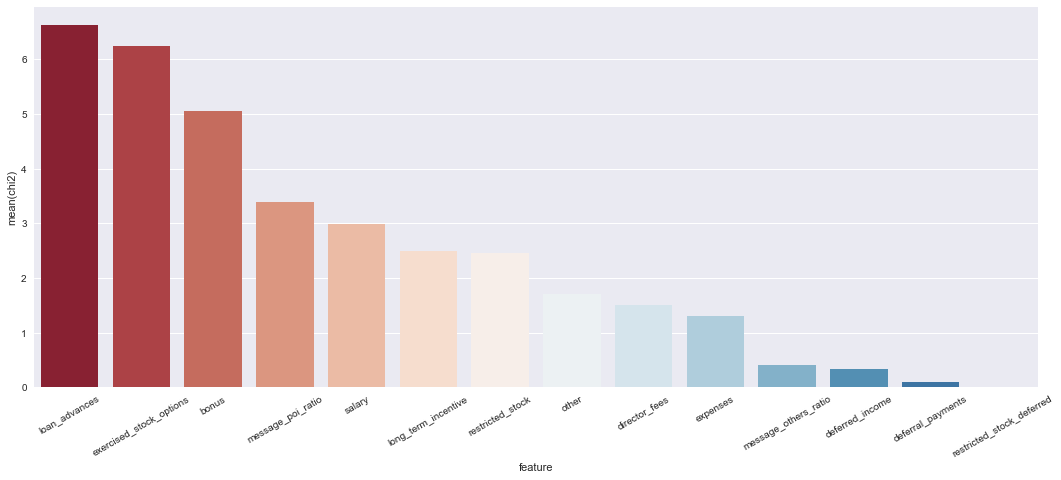

In [24]:
# Corr heatmap
f, ax = plt.subplots(figsize=(18,7))

sb.barplot(x='feature', y='chi2', data=kbest_pd.sort_values(by='chi2',ascending = False), palette='RdBu')

plt.xticks(rotation=30);

The two metrics returned similar values of importance for the features. They differed only in the loan_advances and salary records.
I'm happy to know that the feature I created message_poi_ratio got a good score.

# 7. Testing models

In [13]:
models = []
# naive_bayes
models.append(('Naive Bayes', GaussianNB()))
# tree
models.append(('DecisionTree', DecisionTreeClassifier(random_state=42)))
# ensemble
models.append(('RandomForest', RandomForestClassifier(n_estimators=100, random_state=42)))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0)))

models.append(('AdaBoost', AdaBoostClassifier(n_estimators=100, random_state=42)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier(n_estimators=100, random_state=42)))
# linear_model
models.append(('LogisticRegression', LogisticRegression(random_state=42)))
# neighbors
models.append(('KNeighbors', KNeighborsClassifier(n_neighbors=5)))
models.append(('NearestCentroid', NearestCentroid()))

accuracy_model = []
score = []
for name, clf in models:  
    tm = time()
    #print "Start testing classifier:", name

    score = test_classifier(clf, my_dataset, features_list)
    accuracy_model.append([name,score[2], score[3], score[1]])
    
scores = pd.DataFrame(accuracy_model,
                      columns=('Model', 
                               'Precision', 
                               'Recall',
                               'Accuracy')).sort_values(by='Accuracy',
                                                    ascending = False)

print scores

                        Model  Precision  Recall  Accuracy
7                  KNeighbors   0.705556  0.1270  0.876533
2                RandomForest   0.441931  0.1465  0.861533
5        ExtraTreesClassifier   0.411685  0.1515  0.858000
4                    AdaBoost   0.418319  0.3060  0.850733
8             NearestCentroid   0.376596  0.2655  0.843467
3  GradientBoostingClassifier   0.260177  0.2205  0.812467
1                DecisionTree   0.252969  0.2450  0.802867
6          LogisticRegression   0.164218  0.1900  0.763067
0                 Naive Bayes   0.219135  0.6230  0.653733


As I'm interested in the three metrics recall, precision and accuracy in the test with basic parameters, the Models NearestCentroid and GradientBoostingClassifier had a score close to the expected of 0.3. Even without tuning the AdaBoost reached the metric with a precision of 0.41, recall of 0.30 and a good percentage of acuracia of 85%.

One of the models has reached the goal, but what if we can increase the precision and recall of the other models? Sounds like a good mission, does not it? We, will try.

# 8. Tuning Algorithm Parameters

## 8.1. GradientBoostingClassifier

In [14]:
pipeline = Pipeline([('scale', StandardScaler(with_mean=False)),
                     ('classify', GradientBoostingClassifier(random_state=42))])

param_grid = {
        'classify__criterion': ['mae', 'friedman_mse', 'mse'],
        'classify__n_estimators' : [50, 100, 150],
        'classify__learning_rate':[0.05, 0.1, 1.0],
        'classify__loss' : ['deviance', 'exponential'],    
        'classify__max_leaf_nodes': [100, 150],
        'classify__max_features': [0.50]       
    }
grid = GridSearchCV(
    pipeline, param_grid=param_grid, cv=10, scoring='accuracy')

grid.fit(features,labels)
clf = grid.best_estimator_
test_classifier(clf, my_dataset, features_list, print_result=True)

Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=False, with_std=True)), ('classify', GradientBoostingClassifier(criterion='mae', init=None, learning_rate=1.0,
              loss='exponential', max_depth=3, max_features=0.5,
              max_leaf_nodes=100, min_impurity_split=1e-07,
           ...        presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False))])
	Accuracy: 0.83473	Precision: 0.31391	Recall: 0.20200	F1: 0.24582	F2: 0.21751
	Total predictions: 15000	True positives:  404	False positives:  883	False negatives: 1596	True negatives: 12117



After a scale and a search for best params with gridsearchCV we improve all of three scores, but I can't  able to achieve a recall greater than 0.30.

| Model                        | Precision |    Recall | Accuracy  |
|------------------------------|-----------|-----------|-----------|
|GradientBoosting before       |   0.26017 |     0.2205|    0.81246|
|GradientBoosting after tuning |   0.31391 |     0.2020|    0.83473|

## 8.2. NearestCentroid

In [11]:
pipeline = Pipeline(steps=[('scale', StandardScaler()),
                           ('reduce_dim', PCA(copy=True, random_state=42)),
                           ('classifier', NearestCentroid())
                          ])

param_grid = {'scale' : [StandardScaler(with_mean=False)],
              'reduce_dim__n_components': [3, 5, 6],
              'classifier__metric': ['cityblock', 'euclidean', 'l1', 'l2', 'manhattan'],
              'classifier__shrink_threshold'  : [0.001, 0.01, 0.1, 1.0]
         }

#scv = StratifiedShuffleSplit(labels_train, 1000, random_state = 42)

grid = GridSearchCV(
    pipeline, param_grid=param_grid, cv=10, scoring='accuracy')

grid.fit(features_train, labels_train)

clf = grid.best_estimator_
test_classifier(clf, my_dataset, features_list, print_result=True)

Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=False, with_std=True)), ('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=5, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('classifier', NearestCentroid(metric='cityblock', shrink_threshold=0.001))])
	Accuracy: 0.81113	Precision: 0.35857	Recall: 0.52800	F1: 0.42710	F2: 0.48241
	Total predictions: 15000	True positives: 1056	False positives: 1889	False negatives:  944	True negatives: 11111



Now I'm happier with the result, although it has reduced Precision and accuracy a bit, there was a significant increase in recall.

| Model                        | Precision |    Recall | Accuracy  |
|------------------------------|-----------|-----------|-----------|
|NearestCentroid before        |    0.37659|     0.2655|    0.84346|
|NearestCentroid after tuning  |    0.35857|     0.5280|    0.81113|

## 8.3. Last but not least...  AdaBoostClassifier

First, I'll tuning the classify that I'll use after as base estimator on Adaboost.

In [13]:
pipeline = Pipeline(steps=[('minmaxer', StandardScaler(with_mean=False)),
                           ('classifier', DecisionTreeClassifier(random_state=42))
                          ])
params = {
          'classifier__max_features': [2, 6, 10],
          'classifier__min_samples_split' : [0.1, .50, .90],
          'classifier__splitter' : ['best' , 'random'],
          'classifier__min_samples_leaf': [1, 3, 10,15],
          'classifier__class_weight' : ['balanced', None],
          'classifier__criterion': ["gini", "entropy"]
        }

grid = GridSearchCV(pipeline, param_grid = params,scoring = 'recall', cv=10)
grid.fit(features_train, labels_train)

clf_dt = grid.best_estimator_

test_classifier(clf_dt, my_dataset, features_list, print_result=True)

Pipeline(steps=[('minmaxer', StandardScaler(copy=True, with_mean=False, with_std=True)), ('classifier', DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=0.5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='random'))])
	Accuracy: 0.69340	Precision: 0.26824	Recall: 0.75200	F1: 0.39543	F2: 0.55266
	Total predictions: 15000	True positives: 1504	False positives: 4103	False negatives:  496	True negatives: 8897



In [21]:
pipeline = Pipeline(steps=[('minmaxer', MinMaxScaler(feature_range=(0, 1))),
                           ('classifier', AdaBoostClassifier(random_state=42))
                               ])
params = {'classifier__base_estimator': [DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                                        max_depth=None, max_features=2, max_leaf_nodes=None,
                                        min_samples_leaf=1,
                                        min_samples_split=0.5, min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=42, splitter='random')], 
          'classifier__n_estimators': [150,200],          
          'classifier__learning_rate' :[0.01, 0.05, 0.1, 1.0],
          'classifier__algorithm' : ['SAMME.R', 'SAMME']
               }

# You can use StratifiedShuffleSplit
#scv = StratifiedShuffleSplit(features_train, 1000, random_state = 42)

# set up gridsearch
grid = GridSearchCV(pipeline, param_grid = params,scoring = 'f1', cv=10)
grid.fit(features_train, labels_train)

clf = grid.best_estimator_

test_classifier(clf, my_dataset, features_list, print_result=True)

Pipeline(steps=[('minmaxer', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurit...ndom_state=42, splitter='random'),
          learning_rate=0.1, n_estimators=150, random_state=42))])
	Accuracy: 0.79020	Precision: 0.34504	Recall: 0.63850	F1: 0.44799	F2: 0.54568
	Total predictions: 15000	True positives: 1277	False positives: 2424	False negatives:  723	True negatives: 10576



We got it! I think I found the one ;)

I tried to reduce dimensionality but did not succeed. So I chose not to use PCA or Kbest.
This model achieves the goal of a score greater than 0.30 for recall and precision.


| Model                           | Precision |    Recall | Accuracy  |
|---------------------------------|-----------|-----------|-----------|
|AdaBoostClassifier before        |    0.41831|     0.3060|    0.85073|
|AdaBoostClassifier after tuning  |    0.34504|     0.6385|    0.79020|

In [112]:
# For each k value get precision, recall and accuracy. 
# This code snippet may take a long time to run, uncomment if you want to calculate the values again.
"""
accuracy_model = []
for k in range(2,8,1):

    pipeline = Pipeline(steps=[("selection", SelectKBest(k=k)),
                                ("classifier", AdaBoostClassifier(random_state=42, 
                                                                  n_estimators = 150,
                                                                  learning_rate = 0.1,
                                                                  algorithm = 'SAMME'))
                              ])

    
    pipeline.fit(features_train, labels_train)

    clf = pipeline

    score = test_classifier(clf, my_dataset, features_list)
    accuracy_model.append([k,score[2], score[3], score[1]])
    
scores = pd.DataFrame(accuracy_model,
                      columns=('K', 
                               'Precision', 
                               'Recall',
                               'Accuracy')).sort_values(by='Accuracy',
                                                    ascending = False)
"""                                                    

In [128]:
"""
scores = scores.sort_values(by='K', ascending = False)
"""

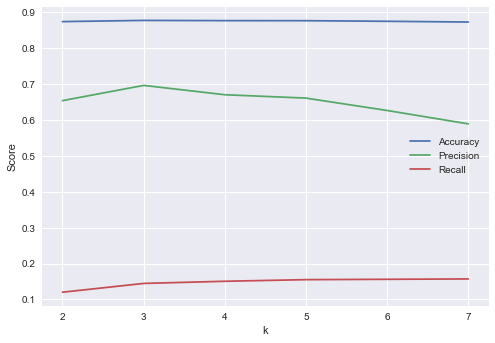

In [135]:
"""
plt.plot(scores['K'],scores['Accuracy'], label='Accuracy')
plt.plot(scores['K'],scores['Precision'], label='Precision')
plt.plot(scores['K'],scores['Recall'], label='Recall')
plt.legend(loc='best')
plt.xlabel('k')
plt.ylabel('Score')
plt.show()
#plt.savefig('scores_k.png')
"""

Unfortunately for the chosen classifier selectKbest method did not improve the performance.

## Now I'm a bit curious...
about how much other models can be improved. Let's continue the tests.

## 8.4. RandomForestClassifier

In [28]:
pipeline =   Pipeline([('scale', MinMaxScaler(feature_range=(0, 1))),
                       ('classifier', RandomForestClassifier())
                      ])

param_grid = {'scale': [None, MaxAbsScaler(), MinMaxScaler(feature_range=(0, 1))],
              'classifier__max_depth': [5, 3, 1],
              'classifier__max_features': [2],
              'classifier__min_samples_leaf': [1, 3, 10,15],
              'classifier__bootstrap': [True, False],
              'classifier__criterion': ['gini', 'entropy']
             }

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=10, scoring='recall')

grid.fit(features_train, labels_train)

clf =  grid.best_estimator_
test_classifier(clf, my_dataset, features_list, print_result=True)

Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=2, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
	Accuracy: 0.86080	Precision: 0.43103	Recall: 0.13750	F1: 0.20849	F2: 0.15918
	Total predictions: 15000	True positives:  275	False positives:  363	False negatives: 1725	True negatives: 12637



No significant improvement:

| Model                           | Precision |    Recall | Accuracy  |
|---------------------------------|-----------|-----------|-----------|
|RandomForest before              |    0.44193|     0.1465|    0.86153|
|RandomForest after tuning        |    0.43103|     0.1375|    0.86080|

## 8.5. KNeighborsClassifier

In [16]:
combined_features = FeatureUnion([("pca", PCA(random_state=42)), 
                                  ("select", SelectKBest()),
                                  ('scale', StandardScaler(with_mean=False))])


pipeline = Pipeline(steps=[('features', combined_features),
                           ('classifier', KNeighborsClassifier())
                          ])

param_grid = {'features__scale' : [None, StandardScaler(with_mean=False)],
              'features__select__k': [6, 10, 14],
              'features__pca__n_components': [10],
              'classifier__metric': ['minkowski','euclidean'],
              'classifier__n_neighbors' : range(2,14,2),
              'classifier__weights' : ['uniform','distance']
             }

grid = GridSearchCV(
    pipeline, param_grid=param_grid, cv=10, scoring='recall')

grid.fit(features_train, labels_train)

clf = grid.best_estimator_
test_classifier(clf, my_dataset, features_list, print_result=True)

Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=False, with_std=True)), ('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='distance'))])
	Accuracy: 0.83980	Precision: 0.39456	Recall: 0.37700	F1: 0.38558	F2: 0.38039
	Total predictions: 15000	True positives:  754	False positives: 1157	False negatives: 1246	True negatives: 11843



This classifier had a decrease in the recall score. Now it has a more balanced values for precision and recall.

| Model                           | Precision |    Recall | Accuracy  |
|---------------------------------|-----------|-----------|-----------|
|KNeighbors before                |    0.70555|     0.1270|    0.87653|
|KNeighbors after tuning          |    0.39456|     0.3770|    0.83980|

## 8.6. LogisticRegression

In [16]:
combined_features = FeatureUnion([("pca", PCA(random_state=42)), 
                                  ('scale', MinMaxScaler(feature_range=(0, 1)))])



pipeline = Pipeline(steps=[('features', combined_features),
                           ('classifier', LogisticRegression(random_state=42))
                          ])

param_grid = {'features__scale': [StandardScaler(with_mean=False), None],
              'features__pca__n_components' :[3,5,6],
              'classifier__C': [0.05, 0.5, 1, 10, 100, 500, 1000],
              'classifier__solver': ['liblinear'],
              'classifier__penalty': ['l2'], 
              'classifier__class_weight': [None, 'balanced']
             }

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=10, scoring='f1')

grid.fit(features_train, labels_train)
clf = grid.best_estimator_
test_classifier(clf, my_dataset, features_list, print_result=True)

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('scale', StandardScaler(copy=True, with_mean=False, with_std=True))],
       transformer_weights=None)), (...alty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])
	Accuracy: 0.78627	Precision: 0.31705	Recall: 0.52250	F1: 0.39464	F2: 0.46255
	Total predictions: 15000	True positives: 1045	False positives: 2251	False negatives:  955	True negatives: 10749



I really liked the improvement achieved in this classifier after tuning. The recall score went from 0.19 to 0.57. This model was a strong candidate, but did not have an accuracy above 80% that was my expectation.

| Model                           | Precision |    Recall | Accuracy  |
|---------------------------------|-----------|-----------|-----------|
|LogisticRegression  before       |    0.16421|     0.1900|    0.76306|
|LogisticRegression  after tuning |    0.31705|     0.5225|    0.78627|

## 8.7. ExtraTreesClassifier

In [32]:
pipeline = Pipeline(steps=[('minmaxer', MinMaxScaler(feature_range=(0, 1))),
                           ('classifier', ExtraTreesClassifier(random_state=42))
                          ])
params = {
          'classifier__max_features': [2, 6, 10],
          'classifier__min_samples_split' : [0.1, .50, .90],
          'classifier__min_samples_leaf': [1, 3, 10,15],
          'classifier__class_weight' : ['balanced', None],
          'classifier__criterion': ["gini", "entropy"]
        }

grid = GridSearchCV(pipeline, param_grid = params,scoring = 'recall', cv=10)
grid.fit(features_train, labels_train)

clf_bs = grid.best_estimator_

test_classifier(clf_bs, my_dataset, features_list, print_result=True)

Pipeline(steps=[('minmaxer', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features=2,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=10, min_samples_split=0.1,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False))])
	Accuracy: 0.63640	Precision: 0.22082	Recall: 0.68300	F1: 0.33374	F2: 0.48146
	Total predictions: 15000	True positives: 1366	False positives: 4820	False negatives:  634	True negatives: 8180



| Model                             | Precision |    Recall | Accuracy  |
|-----------------------------------|-----------|-----------|-----------|
|ExtraTreesClassifier  before       |    0.41168|     0.1515|    0.85800|
|ExtraTreesClassifier  after tuning |    0.22082|     0.6830|    0.63640|

# Conclusion

I was pleased with the improvement in the result of the classifier, but I would like to achieved a higher precision score for AdaBoost classifier.

This classifier for the proposed task of identifying those involved with fraud would require a much larger training database, with more examples to increase the model's ability to identify POIs in a given set of data.